## Building The Country Page Widgets

Charlie has added the following datasets to the **STAGING** API for the construction of the new country pages widgets. This notebook details how to query these datasets to create a the required widgets.


Note: many queries will be repeated, but the data used in different ways, so we should cache the responses for re-use.

```
[
    {
        "name": "IFL 2000",
        "gain": "27ed6d3c-89e8-4087-aa78-1b6619c0e8d5",
        "loss": "cbf299f8-f365-4ba3-ad10-b8c1324bea62",
        "extent": "1676bb7f-a858-4298-8faa-c85cb169ca20"
    },

    {
        "name": "IFL 2013",
        "gain": "19be9cf6-3dfc-4b77-b95e-39a6751e55bf",
        "loss": "2a4bf55c-7e0e-45cd-ac3f-f1e890c0bd22",
        "extent": "2cfc35b0-aa9b-4939-8265-ee643b3afeb5"
    },

    {
        "name": "wdpa",
        "gain": "23519a73-f4b8-4bb6-8a6a-1d84c38debca",
        "loss": "9289fdf7-b2b0-4cbf-8951-9dd4dcd8ccd7",
        "extent": "8d7e23ec-bc8c-4434-bc6a-6ce40459b424"
    },

    {
        "name": "primary forests",
        "gain": "fd3b3a12-121e-4189-96a3-d8c26b70952d",
        "loss": "7a5b92ab-2d35-45f3-b923-20c9a46d4873",
        "extent": "b987b360-190e-4560-a632-03946347d226"
    },

    {
        "name": "biodiversity hot spots",
        "gain": "bd061864-8efb-41a7-8ba0-6f4d25ed1fd8",
        "loss": "32a963c1-26d7-4a21-b602-17144fd78c0f",
        "extent": "6c00c104-a75b-4b0b-9c33-0d0aa29cdf93"
    },

    {
        "name": "gadm28 only",
        "gain": "e78a9c36-ed15-467a-babd-0a5ac21d07d7",
        "loss": "88994c38-1ea1-4a32-82ca-073547d11176",
        "extent": "f0e01525-9576-4613-a74b-3290c94047ca"
    },

    {
        "name": "GFW Plantations",
        "gain": "94a883de-4eb4-4be8-a05f-c77ea8d9c6a3",
        "loss": "17a7970a-23ba-45ab-8004-37090b4e2502",
        "extent": "9b617bbb-b99b-4543-832d-665adeec3341"
    },

    {
        "name": "GFW Managed Forests",
        "gain": "c88957d7-4635-4fb7-b729-db565122529d",
        "loss": "c500cb21-fdf0-426b-9a89-4a581f33ed18",
        "extent": "f9e40f0f-4f9f-4d93-957d-1fa15dd29333"
    }
]
```

In [4]:
import requests
import requests_cache
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
requests_cache.install_cache('demo_cache')

Testing basic queries

In [2]:
# Example of what is in the data tables and how to simply read them:
#ds = "6c00c104-a75b-4b0b-9c33-0d0aa29cdf93" # biodiversity
#ds = "8d7e23ec-bc8c-4434-bc6a-6ce40459b424" #wdpa
#ds = "f0e01525-9576-4613-a74b-3290c94047ca"# gadm28 tree cover extent UMD 2010
ds = "f9e40f0f-4f9f-4d93-957d-1fa15dd29333" # managed forests (should be in canada)
url = "https://staging-api.globalforestwatch.org/query"
sql = (f"SELECT * FROM {ds} WHERE iso = 'CAN'and thresh=75 LIMIT 5")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
r.json()

https://staging-api.globalforestwatch.org/query?sql=SELECT+%2A+FROM+f9e40f0f-4f9f-4d93-957d-1fa15dd29333+WHERE+iso+%3D+%27CAN%27and+thresh%3D75+LIMIT+5
Status: 200


{'data': [{'_id': 'AV5S4OAJD0oexj_vOR7q',
   'adm1': 3,
   'adm2': 58,
   'area': 37146.706833403005,
   'iso': 'CAN',
   'thresh': 75},
  {'_id': 'AV5S4OAJD0oexj_vOR72',
   'adm1': 3,
   'adm2': 60,
   'area': 1347463.9138044885,
   'iso': 'CAN',
   'thresh': 75},
  {'_id': 'AV5S4OAJD0oexj_vOR78',
   'adm1': 3,
   'adm2': 54,
   'area': 22280.92607727738,
   'iso': 'CAN',
   'thresh': 75},
  {'_id': 'AV5S4OAJD0oexj_vOR8H',
   'adm1': 3,
   'adm2': 56,
   'area': 40803.13177967282,
   'iso': 'CAN',
   'thresh': 75},
  {'_id': 'AV5S4OAJD0oexj_vOR8e',
   'adm1': 9,
   'adm2': 154,
   'area': 0.6535985444833999,
   'iso': 'CAN',
   'thresh': 75}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
     'datasetUrl': '/v1/query/f9e40f0f-4f9f-4d93-957d-1fa15dd29333'}},
   'http_method': 'POST',
   'url': '/v1/dataset/f9e40f0f-4f9f-4d93-957d-1fa15dd29333/clone'}}}

# Obtain metadata for admin0 to admin2 level

Retrieve json mappings of id values (e.g. iso codes or integers) for admin0 to admin2 level, and map them to english names for selectors and resources to build dynamic sentences.

In [3]:
def get_admin0_json(urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """return an alphabetical json of mappings of iso and country names
    e.g.
    [{'iso': 'AFG', 'name': 'Afghanistan'},
     {'iso': 'XAD', 'name': 'Akrotiri and Dhekelia'},
     {'iso': 'ALA', 'name': 'Åland'},
     ...
    ]
    
    """
    sql = ("SELECT iso, country as name FROM umd_nat_staging "
            "GROUP BY iso, name "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})
    return r.json().get('rows', None)
 

def get_admin1_json(iso, urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """return an alphabetical json of mappings of admin1 for a country
    e.g. for iso='GBR'
        [{'adm1': 1, 'name': 'England'},
         {'adm1': 2, 'name': 'Northern Ireland'},
         {'adm1': 3, 'name': 'Scotland'},
         {'adm1': 4, 'name': 'Wales'}]
    """
    sql = ("SELECT id1 as adm1, region as name "
            "FROM umd_subnat_staging "
            f"WHERE iso = '{iso}' "
            "and year = 2001 "
            "and thresh = 30 "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})
    return r.json().get('rows', None)
   

def get_admin2_json(iso, adm1, urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """ 
    e.g. response for iso='GBR' adm1=1
    [{'adm2': 1, 'name': 'Barking and Dagenham'},
     {'adm2': 2, 'name': 'Bath and North East Somerset'},
     ...
     ]

    """
    sql = ("SELECT id_2 as adm2, name_2 as name "
            "FROM gadm28_adm2 "
            f"WHERE iso = '{iso}' "
            f"AND id_1 = {adm1} "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})    
    return r.json().get('rows', None)

In [4]:
tmp = get_admin0_json()
iso_to_countries = {}
for row in tmp:
    iso_to_countries[row.get('iso')] = row.get('name')

# Get info on an areas shape

Use the Geostore service to find the geometry, bounding box or additional info on a given `iso` or `iso/admin1` area.

Note - if similar info is needed for admin2 areas I will have to go back and create a query based on a Carto table, as admin-2 level data does not exist in the geostore service yet.

In [5]:
iso = "GBR"
adm1 = None 

if not adm1:
    print("returning admin-0 level geostore")
    url = f"https://api.resourcewatch.org/v1/geostore/admin/{iso}"
else:
    print("returning admin-1 level geostore")
    url = f"https://api.resourcewatch.org/v1/geostore/admin/{iso}/{adm1}"
    
r = requests.get(url)
print(r.url)
roi = r.json()

print(roi.get('data', None).get('attributes', None).keys())
roi.get('data').get('attributes').get('bbox')  #e.g. of getting the bounding box of a ROI

returning admin-0 level geostore
https://api.resourcewatch.org/v1/geostore/admin/GBR
dict_keys(['geojson', 'hash', 'provider', 'areaHa', 'bbox', 'lock', 'info'])


[-13.6913900375365, 49.8654174804688, 1.76416802406322, 60.8458213806153]

In [6]:
def create_bounding_poly(bbox):
    """Create a bounding polygon from a returned bbox of the geostore service
        (- the old api produced shapes in this format).
    """
    lat1, lon1, lat2, lon2  = bbox
    return [[lat1,lon1], [lat1,lon2],[lat2,lon2],[lat2,lon1] ,[lat1,lon1]]

In [7]:
create_bounding_poly(roi.get('data').get('attributes').get('bbox'))

[[-13.6913900375365, 49.8654174804688],
 [-13.6913900375365, 60.8458213806153],
 [1.76416802406322, 60.8458213806153],
 [1.76416802406322, 49.8654174804688],
 [-13.6913900375365, 49.8654174804688]]

# Set up global (scope) data sources for the Country Widgets 

The country widgets can all access and depend on a single json object for linking to the datasets.
The keys of this object are the human readable values that should go into the `LOCATION` menu drop-down.
The sub-keys (e.g. `gain`) refer to the type of data held in the table.

There is some work that needs to be done in populating the Location menu however, as not all options should be always available: some of them will need to be iso dependent.

e.g. 

 managed forests should only appear in the menu if the ISO is set to one of the following:
` ['CMR','CAN','CAF', 'COD','GNQ','GAB','IDN','LBR','COG']`


In [8]:
data_sources = {
                'Intact Forest Landscapes (2000)':{
                    "name": "IFL 2000",
                    "gain": "27ed6d3c-89e8-4087-aa78-1b6619c0e8d5",
                    "loss": "cbf299f8-f365-4ba3-ad10-b8c1324bea62",
                    "extent": "1676bb7f-a858-4298-8faa-c85cb169ca20"
                },

                'Intact Forest Landscape (2013)':{
                    "name": "IFL 2013",
                    "gain": "19be9cf6-3dfc-4b77-b95e-39a6751e55bf",
                    "loss": "2a4bf55c-7e0e-45cd-ac3f-f1e890c0bd22",
                    "extent": "2cfc35b0-aa9b-4939-8265-ee643b3afeb5"
                },

                'Protected Areas':{
                    "name": "wdpa",
                    "gain": "23519a73-f4b8-4bb6-8a6a-1d84c38debca",
                    "loss": "9289fdf7-b2b0-4cbf-8951-9dd4dcd8ccd7",
                    "extent": "8d7e23ec-bc8c-4434-bc6a-6ce40459b424"
                },

                'Primary Forests':{
                    "name": "primary forests",
                    "gain": "fd3b3a12-121e-4189-96a3-d8c26b70952d",
                    "loss": "7a5b92ab-2d35-45f3-b923-20c9a46d4873",
                    "extent": "b987b360-190e-4560-a632-03946347d226"
                },

                'Biodiversity Hotspots':{
                    "name": "biodiversity hot spots",
                    "gain": "bd061864-8efb-41a7-8ba0-6f4d25ed1fd8",
                    "loss": "32a963c1-26d7-4a21-b602-17144fd78c0f",
                    "extent": "6c00c104-a75b-4b0b-9c33-0d0aa29cdf93"
                },

                'All Region':{
                    "name": "gadm28 only",
                    "gain": "e78a9c36-ed15-467a-babd-0a5ac21d07d7",
                    "loss": "88994c38-1ea1-4a32-82ca-073547d11176",
                    "extent": "f0e01525-9576-4613-a74b-3290c94047ca"
                },

                'Tree Plantations':{
                    "name": "GFW Plantations",
                    "gain": "94a883de-4eb4-4be8-a05f-c77ea8d9c6a3",
                    "loss": "17a7970a-23ba-45ab-8004-37090b4e2502",
                    "extent": "9b617bbb-b99b-4543-832d-665adeec3341"
                },

                'Managed Forests':{
                    "name": "GFW Managed Forests",
                    "gain": "c88957d7-4635-4fb7-b729-db565122529d",
                    "loss": "c500cb21-fdf0-426b-9a89-4a581f33ed18",
                    "extent": "f9e40f0f-4f9f-4d93-957d-1fa15dd29333"
                }
}

# Tree cover widget

The default view for the tree cover widget should be for 'All Region'.
We provide a mapping between the text to select in the Location drop-down and the dataset IDs that need to be called in conjunction with a specific selection.


For the default  "All Region" location, we will need to show 3 slices in the donut chart:
    * Tree plantations
    * Natural forest (tree cover 2010 - tree plantations)
    * Non-forest (total area - tree cover 2010)

We show how to calculate this below.

**BUT**

If other Locations are selected, (e.g. Protected Areas), we need a different donut chart. One with less data (only tree cover, and non-forest).

    * Tree cover 
    * Non-forest



*Notes: below this line are extra notes not needed for Front-end dev*

** Area selectors:**
* Priority 1:
        All region,
        WDPA,
        moratorium areas,
        peat
* PRIORITY 2:
        oil palm concessions,
        mining concessions,
        managed forests,
        wood fiber concessions,
        Landmark (select countries)
** Same info from another source/comment**        
* MVP selectors:
    - All region
    - IFLs
    - mangroves
    - tree plantations
    - natural forest
    - primary forest

- adm0 = BRA, adm1 = 4  is Amazonas
- adm0 = BRA, adm1 = 4, adm2 = 141 is Amaturá  (many forests)
- adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres
- adm0 = BRA, adm1 = 14, adm2 = 2404 is Para, Altamira 
- adm0 = BRA, adm1 = 16, adm2 = 3135 - largest area of plantations (Turning this on seems to reveal a bug)


In [9]:
# VARIABLES FOR TREE COVER WIDGET

url = "https://staging-api.globalforestwatch.org/query"
adm0 = 'BRA'
threshold = 0
adm1 = None
adm2 = None
location = 'All Region'  

In [10]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [11]:
def extent_queries(ds, adm0, adm1=None, adm2 = None, threshold=30):
    if adm0 and not adm1 and not adm2:
        print('Request for adm0 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND thresh = {threshold}")
    elif adm0 and adm1 and not adm2:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND thresh = {threshold}")
    elif adm0 and adm1 and adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT area as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND adm2 = {adm2} AND thresh = {threshold}") 
    return sql

In [12]:
sql = extent_queries(ds=data_sources.get(location).get('extent'),
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

Request for adm0 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+f0e01525-9576-4613-a74b-3290c94047ca+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0
Status: 200
{'data': [{'value': 245474257.59415054}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/f0e01525-9576-4613-a74b-3290c94047ca'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/f0e01525-9576-4613-a74b-3290c94047ca/clone'}}}

BRA None None Gadm28 Tree cover extent = 245474257.59415054 ha


NOTES:
*So far I don't like this value. It is way too low: the 2000 UMD extent data for Brazil gives 519,187,505 ha *
*From this table we are getting 244,872,188 ha. Doesn't look right...*

In [13]:
# We need an area for the plantations for some of the locations
# This should be the area of UMD forest cover intersecting tree plantations at admin2 level

if location in ['All Region']:
    sql = extent_queries(ds=data_sources.get('Tree Plantations').get('extent'), adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        plantations = r.json().get('data')[0].get('value')
    except:
        plantations = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")
else:
    print(f"No plantation data neded for '{location}'")
    plantations = None

Request for adm0 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+9b617bbb-b99b-4543-832d-665adeec3341+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0
Status: 200
{'data': [{'value': 5244799.499295063}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/9b617bbb-b99b-4543-832d-665adeec3341'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/9b617bbb-b99b-4543-832d-665adeec3341/clone'}}}

BRA None None plantation area = 5244799.499295063 ha


In [14]:
def area_queries(adm0, adm1=None, adm2 = None):
    """If an admin0 or admin 1 area is requestd, use precalulated tables.
       If an admin2 is requested, calculate the area from the geometry.
    """
    if adm0 and not adm1 and not adm2:
        print('Request for adm0 area')
        sql = ("SELECT land as value "
                "FROM umd_nat_staging "
               f"WHERE iso = '{adm0}' "
                " AND year = 2001 "
                " and thresh = 30 ")
    elif adm0 and adm1 and not adm2:
        print('Request for adm1 area')
        sql = ("SELECT land as value "
                "FROM umd_subnat_staging "
               f"WHERE iso = '{adm0}' "
               f" AND id1 = {adm1} "
                " AND year = 2001 "
                " and thresh = 30 ")
    elif adm0 and adm1 and adm2:
        print('Request for adm2 area')
        sql = ("SELECT ROUND(ST_AREA(the_geom::geography) * 0.0001) as value "
                "FROM gadm28_adm2 "
                f"WHERE iso = '{adm0}' "
                f"AND id_1 = {adm1} "
                f"AND id_2 = {adm2} ")
    return sql

In [15]:
# Total area (ha) of selected area based on a mix of pre-calculated areas and gadm28 admin2 shapes
# table both in the WRI-01 Carto account

sql = area_queries(adm0=adm0, adm1=adm1, adm2=adm2)

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

total_area = r.json().get('rows')[0].get('value')
print(f"\n {total_area} ha total area selected")

Request for adm0 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+land+as+value+FROM+umd_nat_staging+WHERE+iso+%3D+%27BRA%27++AND+year+%3D+2001++and+thresh+%3D+30+ 

{'fields': {'value': {'type': 'number'}},
 'rows': [{'value': 853281125.672}],
 'time': 0.007,
 'total_rows': 1}

 853281125.672 ha total area selected


In [16]:
#  Note if plantations are 0 - this situation should be considered the same as if plantation data 
# were not to be included. I.e. if plantation = 0 then 

if location in ['All Regions']:
    print(f"plantations={plantations:g}, tree cover={tree_cover_extent_2010:g}, area={total_area:g}")
else:
    print(f"tree cover={tree_cover_extent_2010:g}, area={total_area:g}")

tree cover=2.45474e+08, area=8.53281e+08


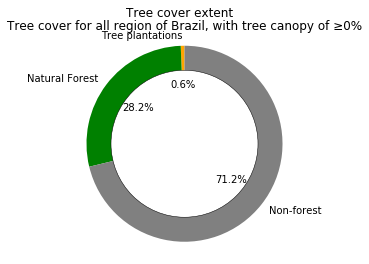

In [17]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
if adm0 and not adm1 and not adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {iso_to_countries[adm0]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and not adm2: 
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm1]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm2]}, "
                        f"with tree canopy of \u2265{threshold}%")


if location in ['All Region']: 
    labels = 'Tree plantations', 'Natural Forest', 'Non-forest'
    sizes = [plantations, tree_cover_extent_2010 - plantations, total_area - tree_cover_extent_2010]
    colors = ['orange','green','grey']
else: 
    labels = 'Tree cover', 'Non-forest'
    sizes = [tree_cover_extent_2010, total_area - tree_cover_extent_2010]
    colors = ['green','grey']
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

#### Problems

** Areas **: As we calculate areas in this case dynamically from geometries, we will get inconsisntent results with the rest of the site. 
To resolve this, we need the areas pre-calculated in a table using the same method that they have previously been calculated from. I.e. it needs to match the same method of the `https://wri-01.carto.com/tables/umd_subnat_staging` table (which currently is at admin1 level.

* Possible Solution: Charlie could produce an areas table, that has the area of the gadm28 geometries.

** Tree Cover **: current extent area is incorrect. For Brazil, nationally, the values are off by around a factor of 2. Perhaps I have the wrong table, but I can't see another possible table that should be used in this case.

** Plantations **: Again, plantation areas look dubious.

## FAO FOREST Widget

This widget should include 'FOREST COVER ' in the title - note the distinction, that the Hansen data relate to tree cover, and FAO relate to forest cover...

An FAO-based forest widget can be calcuated based on data in a carto table `https://wri-01.carto.com/tables/gfw2_countries`

It will take a little work, as the data stored in the carto table is % of primary, regenerated and planted forest. Therefore we must 1) get an area (ha) extent of the forest, 2) obtain the % values of various FAO forest statistics from the carto table, 3) derrive the real (ha) area of FAO forest for each category, and 4) get a value of absolute area of the country and subtract the values caluclated in step 3 from the total area to get non-forest. 

** Pie categories **

* Primary Forest
* Naturally Regenerated Forest
* Planted Forest
* Non-forest

**Notes** 

1. These data (and therefore this widget) is only avaiable at the NATIONAL (ADMIN 0) level. And should dissapear from the pages if any other area is selected.

1. These data have no threshold selection.

1. As these data are only national, we can simply rely on the `umd_nat_staging` table to provide areas directly, rather than needing to dynamically calculate the areas.

In [18]:
# For FAO data, only country (admin0) level data are avaiable. No other options on selector.

# Variables
adm0 = 'BRA'

In [19]:
# First, get the FAO data from a carto table

sql = ("SELECT fao.iso, fao.name,forest_planted, forest_primary, "
         "forest_regenerated, fao.forest_primary, fao.extent, a.land as area_ha "
         "FROM gfw2_countries as fao "
         "INNER JOIN umd_nat_staging as a "
         "ON fao.iso=a.iso "
         "WHERE fao.forest_primary is not null "
         f"AND fao.iso = '{adm0}' "
         "AND a.year = 2001 "
         "AND a.thresh = 30 "
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

fao_percent = r.json().get('rows')[0]

https://wri-01.carto.com/api/v2/sql?q=SELECT+fao.iso%2C+fao.name%2Cforest_planted%2C+forest_primary%2C+forest_regenerated%2C+fao.forest_primary%2C+fao.extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+is+not+null+AND+fao.iso+%3D+%27BRA%27+AND+a.year+%3D+2001+AND+a.thresh+%3D+30+ 

{'fields': {'area_ha': {'type': 'number'},
            'extent': {'type': 'number'},
            'forest_planted': {'type': 'number'},
            'forest_primary': {'type': 'number'},
            'forest_regenerated': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'}},
 'rows': [{'area_ha': 853281125.672,
           'extent': 492968489,
           'forest_planted': 2,
           'forest_primary': 41,
           'forest_regenerated': 57,
           'iso': 'BRA',
           'name': 'Brazil'}],
 'time': 0.009,
 'total_rows': 1}


In [20]:
# How to calculate the statitics needed based on the CARTO responses

naturally_regenerated =  fao_percent['extent']/ 100 *  fao_percent['forest_regenerated']
primary_forest = fao_percent['extent']/100 *  fao_percent['forest_primary']
planted_forest = fao_percent['extent']/100 * fao_percent['forest_planted']
non_forest = fao_percent['area_ha'] - (naturally_regenerated + primary_forest + planted_forest)

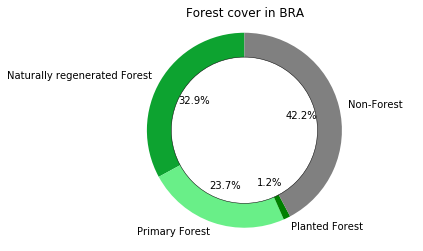

In [21]:
# FAO donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
labels = ['Naturally regenerated Forest', 'Primary Forest', 'Planted Forest', 'Non-Forest']
sizes = [naturally_regenerated, primary_forest, planted_forest, non_forest]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {adm0}')
plt.show()

In [22]:
## RANK ALL COUNTRIES RELATIVE AMOUNT OF PRIMARY FOREST in 2015 and report that value for a dynamic sentence

sql = ("WITH mytable AS (SELECT fao.iso, fao.name, fao.forest_primary, fao.extent forest_extent, a.land as area_ha "
"FROM gfw2_countries as fao "
"INNER JOIN umd_nat_staging as a "
"ON fao.iso=a.iso "
"WHERE fao.forest_primary > 0 "
"AND a.year = 2001 "
"AND a.thresh = 30), "
"rank AS ( "
"SELECT forest_extent * (forest_primary/100)/area_ha * 100 as percent_primary ,iso "
"from mytable "
"ORDER BY percent_primary DESC), "
f"item as (select percent_primary from rank where iso = '{adm0}') "
"select count(*) as rank "
"from rank "
"WHERE percent_primary > (select percent_primary from item) ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank = r.json().get('rows')[0].get('rank')
print(rank)

https://wri-01.carto.com/api/v2/sql?q=WITH+mytable+AS+%28SELECT+fao.iso%2C+fao.name%2C+fao.forest_primary%2C+fao.extent+forest_extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+%3E+0+AND+a.year+%3D+2001+AND+a.thresh+%3D+30%29%2C+rank+AS+%28+SELECT+forest_extent+%2A+%28forest_primary%2F100%29%2Farea_ha+%2A+100+as+percent_primary+%2Ciso+from+mytable+ORDER+BY+percent_primary+DESC%29%2C+item+as+%28select+percent_primary+from+rank+where+iso+%3D+%27BRA%27%29+select+count%28%2A%29+as+rank+from+rank+WHERE+percent_primary+%3E+%28select+percent_primary+from+item%29+ 

{'fields': {'rank': {'type': 'number'}},
 'rows': [{'rank': 27}],
 'time': 0.037,
 'total_rows': 1}
27


In [23]:
# Dyanmic sentence for FAO plot

print(f"FAO data from 2015 shows that {iso_to_countries[adm0]} is ", end="")

if  non_forest/fao_percent['area_ha'] > 0.5:
    print('mostly non-forest. ', end="")
else:
    print('mostly forest. ',end="")

if primary_forest > 0:
    print(f"Primary forest occupies {primary_forest/fao_percent['area_ha']*100:3.1f}% of the country. ", end="")
    print(f"This gives {iso_to_countries[adm0]} a rank of {rank}th out of 110 countries in terms of ", end="")
    print("its relative amount of primary forest.")

FAO data from 2015 shows that Brazil is mostly forest. Primary forest occupies 23.7% of the country. This gives Brazil a rank of 27th out of 110 countries in terms of its relative amount of primary forest.


## TREE COVER LOSS WIDGET 

The UMD/Hansen Tree cover loss widget should be a bar chart, with time as the x-axis, and loss (ha) as the y-axis, on hover it should show the year, ha loss, and % loss relative to 2000 tree cover extent *for the data table of interest*.

** Notes ** 

* Loss data tables have loss units in both area (ha) and emissions (t co2/ha). The emissions units will only be used in the loss widget to add contextual info to the dynamic sentence.

* It is probably best to always request the full time period of data from the table, and then subset it client-side, as we will always need to know the last year of loss to construct the dynamic sentence.

* In settings, the users should be able to change the data sources, when they do you will need to query different data tables both for calculating loss and extent (to calculate relative loss):
    - All region (default) view: gadm28 table
    - all other data tables currently created should be selectable too
    
*more info - not needed for front-end devs*
- for refrence in testing adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres


In [24]:
# Variables

threshold=30
adm0 = 'BRA'
adm1 = None
adm2 = None
start=2000
end=2016
location = "All Region"

In [25]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [26]:
def loss_queries(ds, adm0, start, end, adm1=None, adm2=None, threshold=30):
    if adm0 and not adm1 and not adm2:
        print(f'Request for adm0 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh={threshold} "
               "GROUP BY year ")
    elif adm0 and adm1 and not adm2:
        print('Request for  adm1 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh= {threshold} "
               "GROUP BY year ")
    elif adm0 and adm1 and adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh= {threshold} "
               "GROUP BY year ")
    return sql

Loss on hover should show % loss relative to Tree cover extent in the year 2010, over the appropriate
region. I.e. if someone is interested in the 'All region' default view, then the loss should come from the `gadm28 loss` table, and the extent (to calculate the relative loss) should come from the `gadm28 extent` table.

Therefore we must calculate loss % also.

In [27]:
url = "https://staging-api.globalforestwatch.org/query"

# First, get the 2010 tree cover extent for your area of interest
sql = extent_queries(ds=data_sources.get(location).get('extent'),
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
print(sql)  # 2010 extent query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())
y2010_relative_extent = r.json().get('data')[0].get('value')


# Next, get the loss data grouped by year
sql = loss_queries(ds=data_sources.get(location).get('loss'), adm0=adm0, start=start, end=end, 
                   adm1=adm1, adm2=adm2, threshold=threshold)    
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

# Extract the year, and loss in hectares, and emissions units, and calculate the relative loss in %
d = {}
for row in r.json().get('data'):
    d[row.get('year')] = {'area_ha': row.get('area'),
                          'area_%': row.get('area')/y2010_relative_extent * 100,
                          'emissions': row.get('emissions'),
                          }
pprint(d)

Request for adm0 area
SELECT SUM(area) as value FROM f0e01525-9576-4613-a74b-3290c94047ca WHERE iso = 'BRA' AND thresh = 30
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+f0e01525-9576-4613-a74b-3290c94047ca+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30
Status: 200
{'data': [{'value': 244872188.7236061}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/f0e01525-9576-4613-a74b-3290c94047ca'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/f0e01525-9576-4613-a74b-3290c94047ca/clone'}}}
Request for adm0 area
SELECT year, sum(area) as area, sum(emissions) as emissions FROM 88994c38-1ea1-4a32-82ca-073547d11176 WHERE iso = 'BRA' AND year => 2000 AND year <= 2016 AND thresh=30 GROUP BY year 
https://staging-api.globalforestwatch.org/query?sql=SELECT+year%2C+sum%28area%29+as+area%2C+sum%28emissions%29+as+emissions+FROM+

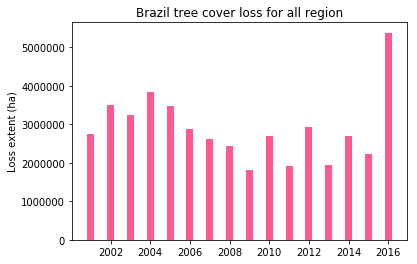

In [28]:
if adm0 and not adm1 and not adm2:
    dynamic_title = (f'{iso_to_countries[adm0]} tree cover loss for {location.lower()}')
if adm0 and adm1 and not adm2: 
    dynamic_title = (f"{areaId_to_name[adm1]} tree cover loss for {location.lower()}")
if adm0 and adm1 and adm2:
    dynamic_title = (f"{areaId_to_name[adm2]} tree cover loss for {location.lower()}")


loss = [val.get('area_ha') for val in d.values()]
years = d.keys()
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(years, loss, width, color='#FE5A8D')


# add some text for labels, title and axes ticks
ax.set_ylabel('Loss extent (ha)')
ax.set_title(dynamic_title)
plt.show()

** ISSUE **

* How is there plantations loss over such a long period? (I was expecting it to start in 2013 only...)

I need to check this with Charlie before I construct the plantations (inside/outside stacked bar version).

** build the dynamic sentence itself for the Tree cover loss widget **

Charlie has confirmed that he has simply intersected hansen data with available polygons. This approach will produce data for times when it doesnt make sense that it exists: need to account for this - do not enable plantation loss before 2013.

#### Dynamic sentence 

For the loss widget we also need a dynamic sentence.

In [29]:
for year in d:
    print(year, d.get(year).get('emissions'), d.get(year).get('area_ha'))

2001 451662674 2743646
2002 599104504 3504343
2003 540572102 3245861
2004 676406325 3846083
2005 644550740 3483878
2006 513805002 2874114
2007 437501960 2619106
2008 421134110 2441599
2009 309399263 1815228
2010 455310957 2686190
2011 323012336 1920608
2012 464004986 2915884
2013 299304381 1942832
2014 414297899 2690455
2015 347406840 2220186
2016 961582786 5376186


In [30]:
# First find total emissions, and loss, and also the last year of emissions and loss

total_emissions = 0
total_loss = 0
for year in d:
    total_loss += d.get(year).get('area_ha')
    total_emissions += d.get(year).get('emissions')

print([total_emissions, total_loss])

[7859056865, 46326199]


In [31]:
# Dynamic sentence construction

if adm0 and not adm1 and not adm2:
    print(f"Between {start} and {end}, {iso_to_countries[adm0]} ({location.lower()}) ", end="")
if adm0 and adm1 and not adm2: 
    print(f"Between {start} and {end},  {location} of {areaId_to_name[adm1].lower()} ", end="")
if adm0 and adm1 and adm2:
    print(f"Between {start} and {end}, {location} of {areaId_to_name[adm2].lower()} ", end="")
    
print(f"lost {total_loss:,.0f} ha of tree cover: ", end="")
print(f"This loss is equal to {total_loss / y2010_relative_extent * 100:3.2f}% of the total ", end="")
print(f"{location.lower()} tree cover extent in 2010, ", end="")
print(f"and equivalent to {total_emissions:,.0f} tonnes of CO\u2082 emissions. ", end="")

Between 2000 and 2016, Brazil (all region) lost 46,326,199 ha of tree cover: This loss is equal to 18.92% of the total all region tree cover extent in 2010, and equivalent to 7,859,056,865 tonnes of CO₂ emissions. 

## HEADER DYNAMIC SENTENCE

The page header needs to contain a dynamic sentence; this sentence is built from the same data tables (and most of the same queries) that we have already used. (Which is why I am describing it here, rather than at the start of the notebook.)

The sentence should be able to account for edge cases where no loss occured (as people will end up looking at admin 2 areas) which may be relativley small, and possibly have no loss.

Be prepared for the need to increase the complexity/comprehensivness of the header sentence over time.

In [32]:
def extract_loss(json_data, last_year=2016):
    """Grab the last loss year of data for area and emissions"""
    for row in json_data:
        if row.get('year') == last_year:
            last_loss = row.get('area')
            last_emissions = row.get('emissions')
    return {'area':last_loss, 'emissions':last_emissions}

In [33]:
last_year = 2016
threshold = 30
adm0 = 'BRA'
adm1 = 14
adm2 = None

In [34]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [35]:
# Get the plantation last year data for the region of interest

sql = loss_queries(ds=data_sources.get('Tree Plantations').get('loss'), adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold, start=start, end = end)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantation_loss_json = r.json().get('data')
plantation_values = extract_loss(plantation_loss_json, last_year=last_year)
print(plantation_values)

Request for  adm1 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+year%2C+sum%28area%29+as+area%2C+sum%28emissions%29+as+emissions+FROM+17a7970a-23ba-45ab-8004-37090b4e2502+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+14+AND+year+%3D%3E+2000+AND+year+%3C%3D+2016+AND+thresh%3D+30+GROUP+BY+year+
Status: 200
{'area': 6235.476380214095, 'emissions': 923635.0995073318}


In [36]:
# Get the gadm28 loss 
gadm28_loss_table = "88994c38-1ea1-4a32-82ca-073547d11176"

sql = loss_queries(ds=data_sources.get('All Region').get('loss'), adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold, start=start, end = end)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantation_loss_json = r.json().get('data')
gadm28_values = extract_loss(plantation_loss_json, last_year=last_year)
print(gadm28_values)

Request for  adm1 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+year%2C+sum%28area%29+as+area%2C+sum%28emissions%29+as+emissions+FROM+88994c38-1ea1-4a32-82ca-073547d11176+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+14+AND+year+%3D%3E+2000+AND+year+%3C%3D+2016+AND+thresh%3D+30+GROUP+BY+year+
Status: 200
{'area': 1573195, 'emissions': 351252336}


In [37]:
# Get total land area (ha) of selected region  - hopefully we can change this soon to use a
# table inthe data_source

sql = area_queries(adm0=adm0, adm1=adm1, adm2=adm2)

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

total_area = r.json().get('rows')[0].get('value')
#print(f"\n {total_area} ha total area selected")

Request for adm1 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+land+as+value+FROM+umd_subnat_staging+WHERE+iso+%3D+%27BRA%27++AND+id1+%3D+14++AND+year+%3D+2001++and+thresh+%3D+30+ 

{'fields': {'value': {'type': 'number'}},
 'rows': [{'value': 125384972.642}],
 'time': 0.103,
 'total_rows': 1}


In [38]:
# Get 2010 tree cover extent of selected area from gadm28 table 

sql = extent_queries(ds=data_sources.get('All Region').get('extent'), adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")


Request for  adm1 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+f0e01525-9576-4613-a74b-3290c94047ca+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+14+AND+thresh+%3D+30
Status: 200
{'data': [{'value': 61655195.54589844}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/f0e01525-9576-4613-a74b-3290c94047ca'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/f0e01525-9576-4613-a74b-3290c94047ca/clone'}}}

BRA 14 None Gadm28 Tree cover extent = 61655195.54589844 ha


In [39]:
# DYNAMIC SENTENCE

if adm0 and not adm1 and not adm2:
    print(f"In 2010, {iso_to_countries[adm0]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")     
if adm0 and adm1 and not adm2: 
    print(f"In 2010, {areaId_to_name[adm1]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")
if adm0 and adm1 and adm2:
    print(f"In 2010, {areaId_to_name[adm2]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")

percent_cover = tree_cover_extent_2010/total_area*100
if percent_cover > 0:
    print(f", extending over {percent_cover:3.1f}% of its land area. ", end="")
else:
    print(". ")

# beware we could have areas with no plantations
try:
    loss_area = int(gadm28_values['area'] - plantation_values['area'])
except:
    loss_area = 0
    
print(f"In {last_year}, ",end="")

if loss_area > 0:
    print(f"it lost {loss_area:,.0f} ha "
          "of forest excluding tree plantations, equivalent to "
          f"{int(gadm28_values['emissions'] - plantation_values['emissions']):,.0f} "
          "tonnes of CO\u2082 of emissions.")
else:
    print("it lost no tree cover (excluding tree plantations).")

In 2010, Pará had 61,655,195 ha of tree cover, extending over 49.2% of its land area. In 2016, it lost 1,566,959 ha of forest excluding tree plantations, equivalent to 350,328,700 tonnes of CO₂ of emissions.


# Tree Cover gain widget

1. Widgets made entireley from a dynamic sentence
2. User Variables (admin0 to admin1 and location)
3. Datasets (All GAIN datasets)


** LOCATION Area Selectors **

    - All region (GADM from admin-0 to admin-2 level)
    - Biodiversity Hotspots
    - Protected Areas
    - Plantations
    - Managed Forests
    - Primary Forests
    - Intact Forests (2000/2013)

** Notes **

- AOI (area of interest) is the gadm region (admin0-2)
- location is the subset of that (i.e protected areas)
- Threshold is not a variable in this widget (it should be hardcoded in the queries and must be set to `thresh = 0`)

In [40]:
# Variables
adm0 = 'BRA'
adm1 = 14
adm2 = None
location = "Tree Plantations"

url = "https://staging-api.globalforestwatch.org/query"

In [41]:
# get admin 1 or 2 level human-readable name info as needed:
areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [42]:
#GAIN QUERY

def gain_query(ds, adm0, adm1=None, adm2 = None):
    """Queries for the gain tables. Note, threshold must be hardcoded to 0
        and that will not change.
    """
    if adm0 and not adm1 and not adm2:
        print('Request for adm0 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND thresh = 0")
    elif adm0 and adm1 and not adm2:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND thresh = 0")
    elif adm0 and adm1 and adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT area as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND adm2 = {adm2} AND thresh = 0") 
    return sql

In [43]:
# gain query
sql = gain_query(ds=data_sources.get(location).get('gain'), adm0=adm0, adm1=adm1, adm2=adm2)
r1 = requests.get(url, params = {"sql": sql})

try:
    tree_cover_gain_2010 = r1.json().get('data')[0].get('value')
except:
    tree_cover_gain_2010 = 0.0
print(r1.url)    
pprint(r1.json())


# Total Extent query
sql = gain_query(ds=data_sources.get(location).get('extent'), adm0=adm0, adm1=adm1, adm2=adm2)
r2 = requests.get(url, params = {"sql": sql})
print(r2.url)
pprint(r2.json())

total_area = r2.json().get('data')[0].get('value')
area_percent = round((100 * tree_cover_gain_2010 / total_area), 2)

Request for  adm1 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+94a883de-4eb4-4be8-a05f-c77ea8d9c6a3+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+14+AND+thresh+%3D+0
{'data': [{'value': 103757}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/94a883de-4eb4-4be8-a05f-c77ea8d9c6a3'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/94a883de-4eb4-4be8-a05f-c77ea8d9c6a3/clone'}}}
Request for  adm1 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+9b617bbb-b99b-4543-832d-665adeec3341+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+14+AND+thresh+%3D+0
{'data': [{'value': 264324.434761405}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/9b617bbb-b99b-4543-832d-665adeec3341'}},
            

In [44]:
#Dynamic sentence

# we may need to modify the way we describe the location to fit gramatically
if location == 'All Region':
    region_phrase = 'region-wide'
else:
    region_phrase = 'in ' + location.lower()


print(f"From 2001 to 2012, ", end="")

if(not adm1 and not adm2):
    print(f"{iso_to_countries[adm0]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ",end="")
    print(f"increase relative to 2010 tree cover extent.", end="")
elif(not adm2):
    print(f"{areaId_to_name[adm1]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ",end="")
    print(f"increase relative to 2010 tree cover extent.", end="")
else:
    print(f"{areaId_to_name[adm2]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ", end="")
    print(f"increase relative to 2010 tree cover extent.", end="")


From 2001 to 2012, Pará gained 264,324 ha of tree cover in tree plantations, equivalent to a 39.25% increase relative to 2010 tree cover extent.

# Rate of Reforestation (FAO) Dynamic Sentence

State the regrowth rate of a country in a given 5-year period.

### Requirements

1. Dynamic sentences for:
    - year
    - Area (Admin0 only)
    - Rate (ha/y)
2. User Variables (area of interest, year)
3. Datasets ([FAO carto table](https://wri-01.carto.com/tables/table_1_forest_area_and_characteristics))
4. Metrics (Rate only)


### Default View

Will show reforestation rate in 2010, country-wide (admin-0 level) including information about:

    * Rate of Reforestation (ha/y)

e.g. dynamic sentences:

"In X year, the rate of reforestation in [country name] was X ha/year."

### Selectors

    - Year (1990, 2000, 2005, 2010)
    - ISO (adm0)

### Notes

- Could add ranking sentence, comparing the regrowth to other nations
- These data (and therefore this widget) is only avaiable at the NATIONAL (ADMIN 0) level. And should dissapear from the pages if any other area is selected.
- These data have no threshold selection.
- As these data are only national, we can simply rely on the `umd_nat_staging` table to provide areas directly, rather than needing to dynamically calculate the areas.
- Data comes from https://wri-01.carto.com/tables/table_1_forest_area_and_characteristics
    * 'Country' = ISO3
    * 1990, 2000, 2005, 2010
    * 'Reforest' = rate (ha/y)
    * 'Forest' = extent of forest cover (1000's of ha)

In [5]:
# For FAO data, only country (admin0) level data and year is avaiable. No other options on selector.

# Variables
adm0 = 'BRA'
year = 2010  #year = (1990, 2000, 2005, 2010)

In [6]:
# First, get the FAO data from a carto table. Note that extent is multiplied by 1000.

sql = ("SELECT country AS iso, name, year, reforest AS rate, forest*1000 AS extent "
         "FROM table_1_forest_area_and_characteristics as fao "
         f"WHERE fao.year = {year} "
         f"AND fao.country = '{adm0}'"
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

data = r.json().get('rows')[0]

https://wri-01.carto.com/api/v2/sql?q=SELECT+country+AS+iso%2C+name%2C+year%2C+reforest+AS+rate%2C+forest%2A1000+AS+extent+FROM+table_1_forest_area_and_characteristics+as+fao+WHERE+fao.year+%3D+2010+AND+fao.country+%3D+%27BRA%27 

{'fields': {'extent': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'},
            'rate': {'type': 'number'},
            'year': {'type': 'number'}},
 'rows': [{'extent': 498458000,
           'iso': 'BRA',
           'name': 'Brazil',
           'rate': 519,
           'year': 2010}],
 'time': 0.002,
 'total_rows': 1}


In [7]:
#Example of available data returning from request
# rate (ha /year)
# extent (ha)

data

{'extent': 498458000,
 'iso': 'BRA',
 'name': 'Brazil',
 'rate': 519,
 'year': 2010}

In [8]:
#Account for year range

if(data['year'] != 1990):
    date_range = 5
else:
    date_range = 10

gain = data['rate']*date_range

In [9]:
#Dynamic sentence

print(f"Between {year} and {year + date_range}, the rate ", end="")
print(f"of reforestation in {data['name']} was {data['rate']} ha/year. ", end="")


Between 2010 and 2015, the rate of reforestation in Brazil was 519 ha/year. 